In [2]:
# !wget https://zenodo.org/records/8238653/files/dataset_aug.zip
# !wget https://zenodo.org/records/8238653/files/labels_aug.zip
# !rm -rf dataset_aug
# !rm -rf labels_aug
# !unzip dataset_aug.zip
# !unzip labels_aug.zip

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import cv2
import time

# Data

In [5]:
#Variables
image_size = 256
in_channel_spec = 9
num_classes = 3
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 10

In [6]:
class DatasetCreator(Dataset):
    def __init__(self, spec_path, labels_path, image_size, channels):
        # Read the Labels file as a dataframe and store the paths to specX,Y, and Z in the same dataframe.
        # Don't load the images now, requires lot of memory.
        # Load in __getitem__()
        self.df = pd.read_csv(labels_path, index_col=0)
        self.df = self.df[~self.df.index.str.contains('Aug')] # Remove Augmented data
        self.df['specX'] = self.df.index.map(lambda id: f'{spec_path}/specX/{id}.png')
        self.df['specY'] = self.df.index.map(lambda id: f'{spec_path}/specY/{id}.png')
        self.df['specZ'] = self.df.index.map(lambda id: f'{spec_path}/specZ/{id}.png')
        self.image_size = image_size
        self.channels = channels

    def __get_df__(self):
        # Just for debugging purpose
        return self.df

    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, idx):
        # place holder for all the three images (each image has 3 channels)
        image = torch.zeros((self.image_size, self.image_size, self.channels))

        # idx_details has every think we need about the entry of that idx
        idx_details = self.df.iloc[idx]

        # Read images
        # Note that we are not converting BGR to RGB because it doesn't matter to the NN
        img_x = cv2.imread(idx_details['specX'])
        res_x = cv2.resize(img_x, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)

        img_y = cv2.imread(idx_details['specY'])
        res_y = cv2.resize(img_y, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)

        img_z = cv2.imread(idx_details['specZ'])
        res_z = cv2.resize(img_z, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)

        image[:, :, :3] = torch.tensor(res_x)
        image[:, :, 3:6] = torch.tensor(res_y)
        image[:, :, 6:] = torch.tensor(res_z)

        label = idx_details['tool_label']

        # transpose(0,2).transpose(1,2) change image to CxHxW from HxWxC
        return image.transpose(0, 2).transpose(1, 2), label -1

In [7]:
spec_path = "../dataset_aug"
labels_path = "../labels_aug/random_distribution"

train_dataset = DatasetCreator(spec_path, os.path.join(labels_path, "train.csv"), image_size, in_channel_spec)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DatasetCreator(spec_path, os.path.join(labels_path, "test.csv"), image_size, in_channel_spec)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = DatasetCreator(spec_path, os.path.join(labels_path, "val.csv"), image_size, in_channel_spec)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Sanity Check
print(len(train_dataset), len(test_dataset), len(val_dataset))

410 48 54


In [9]:
df_train = train_dataset.__get_df__()

In [10]:
df_train.head()

,image_label,tool_label,specX,specY,specZ
id,,,,,
T6R1B4,sharp,1,../dataset_aug/specX/T6R1B4.png,../dataset_aug/specY/T6R1B4.png,../dataset_aug/specZ/T6R1B4.png
T2R3B2,sharp,1,../dataset_aug/specX/T2R3B2.png,../dataset_aug/specY/T2R3B2.png,../dataset_aug/specZ/T2R3B2.png
T9R11B1,used,2,../dataset_aug/specX/T9R11B1.png,../dataset_aug/specY/T9R11B1.png,../dataset_aug/specZ/T9R11B1.png
T9R3B1,sharp,1,../dataset_aug/specX/T9R3B1.png,../dataset_aug/specY/T9R3B1.png,../dataset_aug/specZ/T9R3B1.png
T6R2B4,sharp,1,../dataset_aug/specX/T6R2B4.png,../dataset_aug/specY/T6R2B4.png,../dataset_aug/specZ/T6R2B4.png


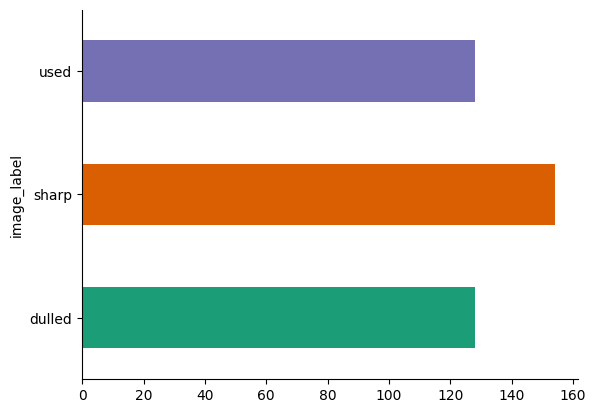

In [13]:
import seaborn as sns

df_train.groupby('image_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Building Model

Best Parameters
- Kernel - 6x6
- Patch size - 32x32
- Filters - 128
- Depth - 4

In [14]:
kernel = (3,3)
patch = 32
filters = 128
depth = 4
padding = (1,1)

In [15]:
class DepthWiseConvolutionBlock(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.dconv = nn.Conv2d(in_channels=filters, out_channels=filters, kernel_size=kernel, stride=1, padding=padding, groups=filters)
        self.activation1 = nn.GELU()
        self.bn1 = nn.BatchNorm2d(num_features=filters)
        self.pconv = nn.Conv2d(in_channels=filters, out_channels=filters, kernel_size=1)
        self.activation2 = nn.GELU()
        self.bn2 = nn.BatchNorm2d(num_features=filters)

    def forward(self, x):
        x0 = x
        _ = self.dconv(x)
        _ = x0 + self.bn1(self.activation1(_))
        _ = self.pconv(_)
        return self.bn2(self.activation2(_))


In [16]:
class BaseBlock(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.conv = nn.Conv2d(in_channels=in_channel_spec, out_channels=filters, stride=patch, kernel_size=patch, padding=0)
        self.activation = nn.GELU()
        self.bn = nn.BatchNorm2d(num_features=filters)

    def forward(self, x):
        _ = self.conv(x)
        _ = self.activation(_)
        return self.bn(_)

In [17]:
# class ClassificationBlock(nn.Module):
#     def __init__(self, *args, **kwargs) -> None:
#         super().__init__(*args, **kwargs)

#         self.pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
#         self.linear = nn.Linear(in_features=filters, out_features=num_classes)

#     def forward(self, x):
#         # print(x.shape)
#         _ = self.pool(x)
#         # print(f"After Avg Pooling: {_.shape}")
#         _ = _.view(x.shape[0], -1)
#         return self.linear(_)

In [18]:
# class SpectogramModel(nn.Module):
#     def __init__(self, *args, **kwargs) -> None:
#         super().__init__(*args, **kwargs)

#         self.model = None
#         layers = [BaseBlock()]
#         for i in range(depth):
#             layers.append(DepthWiseConvolutionBlock())
#         layers.append(ClassificationBlock())
#         self.model = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.model(x)

In [19]:
class SpectogramModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.model = None
        layers = [BaseBlock()]
        for i in range(depth):
            layers.append(DepthWiseConvolutionBlock())
        self.model = nn.Sequential(*layers)
        # CLassification
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.linear = nn.Linear(in_features=filters, out_features=num_classes)


    def forward(self, x):
        _ = self.model(x)
        _ = self.pool(_)
        _ = _.view(x.shape[0], -1)
        return self.linear(_)

In [20]:
# Sanity Test
model = SpectogramModel()
loss_func = nn.CrossEntropyLoss()
x = torch.zeros((batch_size, 9, 256, 256))
y = torch.randint(0, 3, (batch_size, ))
y_pred = model(x)
loss = loss_func(y_pred, y)
loss.backward()

print(loss)
# print(y, y_pred)

tensor(1.1001, grad_fn=<NllLossBackward0>)


In [21]:
model

SpectogramModel(
  (model): Sequential(
    (0): BaseBlock(
      (conv): Conv2d(9, 128, kernel_size=(32, 32), stride=(32, 32))
      (activation): GELU(approximate='none')
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DepthWiseConvolutionBlock(
      (dconv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (activation1): GELU(approximate='none')
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pconv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (activation2): GELU(approximate='none')
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): DepthWiseConvolutionBlock(
      (dconv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (activation1): GELU(approximate='none')
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True,

# Train

In [22]:
use_cuda = torch.cuda.is_available()
device = 'cpu'
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using cuda


In [23]:
def train(model, dataloader, optimizer, loss_func, device):
    model.train()
    model = model.to(device)
    total_loss, total_count, acc_count = 0, 0, 0

    for idx, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # print(X.shape)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_func(y_pred, y)
        loss.backward()
        optimizer.step()

        # Loss
        total_loss += loss.item()
        total_count += X.size(0) # Batch size

        # Accuracy
        _, y_pred_class = y_pred.max(dim=1)
        # print((y_pred_class == y).sum().item())
        acc_count += (y_pred_class == y).sum().item()

    return total_loss/total_count, acc_count/total_count

In [24]:
def evaluate(model, dataloader, loss_func, device):
    model.eval()
    model = model.to(device)
    total_loss, total_count, acc_count = 0, 0, 0
#     print("Evaluate")

    with torch.no_grad():
        for idx, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)

            y_pred = model(X)
            loss = loss_func(y_pred, y)

            total_loss += loss.item()
            total_count += X.size(0)

            # Accuracy
            _, y_pred_class = y_pred.max(dim=1)
            # print((y_pred_class == y).sum().item())
            acc_count += (y_pred_class == y).sum().item()

    return total_loss/total_count, acc_count/total_count

In [25]:
model = SpectogramModel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()
train_loss_epochs = []
val_loss_epochs = []
train_acc_epochs = []
val_acc_epochs = []


for epoch in range(0, num_epochs):
    start = time.time()
    epoch_start_time = time.time()
    loss_train, train_acc = train(model, train_dataloader, optimizer, loss_func, device)
    loss_val, val_acc = evaluate(model, val_dataloader, loss_func, device)

    train_loss_epochs.append(loss_train)
    val_loss_epochs.append(loss_val)
    train_acc_epochs.append(train_acc)
    val_acc_epochs.append(val_acc)
    end = time.time()

    print("=" * 102)
    print(f"| Epoch {epoch}/{num_epochs} | time: {(end-start):.3f} | Train Loss: {loss_train:.3f} | Val Loss: {loss_val:.3f} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} |")
    # print(f"| End of epoch {epoch} | time: {(end-start)} | Train Loss: {loss_train} | Val Loss: {loss_val} | Train Acc: {train_acc} | Val Acc: {val_acc} |")

| Epoch 0/10 | time: 38.466 | Train Loss: 0.016 | Val Loss: 0.022 | Train Acc: 0.554 | Val Acc: 0.222 |
| Epoch 1/10 | time: 8.120 | Train Loss: 0.011 | Val Loss: 0.020 | Train Acc: 0.722 | Val Acc: 0.500 |
| Epoch 2/10 | time: 7.982 | Train Loss: 0.009 | Val Loss: 0.023 | Train Acc: 0.773 | Val Acc: 0.444 |
| Epoch 3/10 | time: 8.169 | Train Loss: 0.008 | Val Loss: 0.056 | Train Acc: 0.798 | Val Acc: 0.333 |
| Epoch 4/10 | time: 8.093 | Train Loss: 0.006 | Val Loss: 0.051 | Train Acc: 0.856 | Val Acc: 0.333 |
| Epoch 5/10 | time: 8.242 | Train Loss: 0.005 | Val Loss: 0.069 | Train Acc: 0.873 | Val Acc: 0.352 |
| Epoch 6/10 | time: 7.992 | Train Loss: 0.004 | Val Loss: 0.013 | Train Acc: 0.910 | Val Acc: 0.630 |
| Epoch 7/10 | time: 7.710 | Train Loss: 0.005 | Val Loss: 0.043 | Train Acc: 0.895 | Val Acc: 0.426 |
| Epoch 8/10 | time: 7.825 | Train Loss: 0.003 | Val Loss: 0.008 | Train Acc: 0.934 | Val Acc: 0.796 |
| Epoch 9/10 | time: 7.501 | Train Loss: 0.003 | Val Loss: 0.034 | Train

In [27]:
test_loss, test_acc = evaluate(model, test_dataloader, loss_func, device)
print("Test Accuracy: ", test_acc)

Test Accuracy:  0.7291666666666666


In [30]:
# Save Model
torch.save(model.state_dict(), "./output/spec/model_d4.pth")

# Save Loss and accuracy
torch.save(train_loss_epochs, "./output/spec/train_loss_epochs_d4.pt")
torch.save(val_loss_epochs, "./output/spec/val_loss_epochs_d4.pt")
torch.save(train_acc_epochs, "./output/spec/train_acc_epochs_d4.pt")
torch.save(val_acc_epochs, "./output/spec/val_acc_epochs_d4.pt")

# Plots

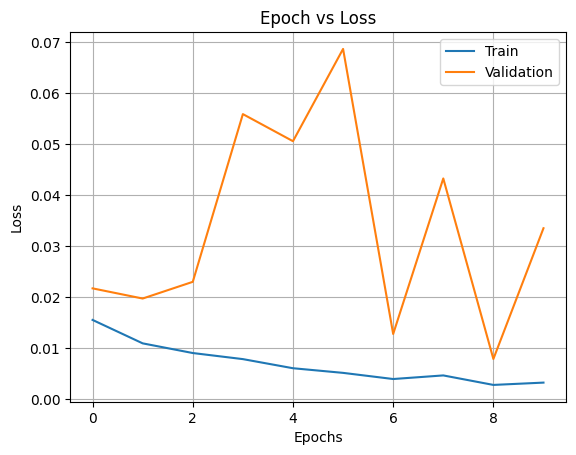

In [28]:
plt.plot(train_loss_epochs, label="Train")
plt.plot(val_loss_epochs, label="Validation")
plt.title("Epoch vs Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

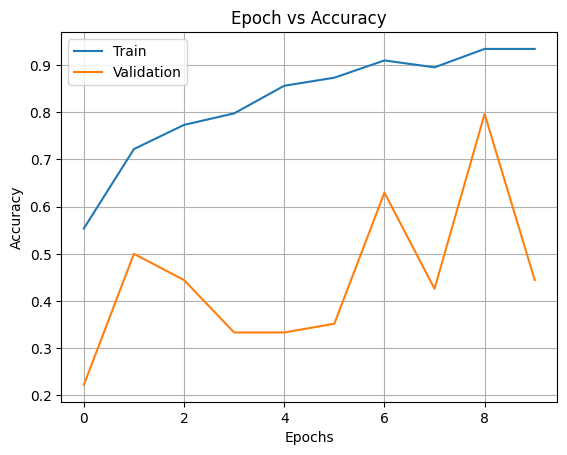

In [29]:
plt.plot(train_acc_epochs, label="Train")
plt.plot(val_acc_epochs, label="Validation")
plt.title("Epoch vs Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()